**M5 Forecasting – Accuracy, Estimate the unit sales of Walmart retail goods**

# Import libraries

In [1]:
import os
import gc
import time
import math
import datetime
from math import log, floor
from sklearn.neighbors import KDTree

import numpy as np
import pandas as pd
from pathlib import Path
from sklearn.utils import shuffle
from tqdm.notebook import tqdm as tqdm

import seaborn as sns
from matplotlib import colors
import matplotlib.pyplot as plt
from matplotlib.colors import Normalize
from itertools import cycle
color_pal = plt.rcParams['axes.prop_cycle'].by_key()['color']
color_cycle = cycle(plt.rcParams['axes.prop_cycle'].by_key()['color'])

import plotly.express as px
import plotly.graph_objects as go
import plotly.figure_factory as ff
from plotly.subplots import make_subplots


import pywt
from statsmodels.robust import mad

from statsmodels.tsa.seasonal import seasonal_decompose
import scipy
from scipy.stats import boxcox
import statsmodels
from scipy import signal
import statsmodels.api as sm
from fbprophet import Prophet
from scipy.signal import butter, deconvolve
from statsmodels.tsa.arima_model import ARIMA
from statsmodels.tsa.api import ExponentialSmoothing
from statsmodels.tsa.holtwinters import ExponentialSmoothing
from sklearn.metrics import mean_squared_error

import warnings
warnings.filterwarnings("ignore")


/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [2]:
from google.colab import files
uploadFile = files.upload()

Saving kaggle.json to kaggle (1).json


In [3]:
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!ls ~/.kaggle
!chmod 600 /root/.kaggle/kaggle.json

kaggle.json


In [4]:
#install kaggle
!pip install -q kaggle
#!pip install -q kaggle-cli

In [5]:
pip install --upgrade plotly

Requirement already up-to-date: plotly in /usr/local/lib/python3.6/dist-packages (4.9.0)


In [6]:
!kaggle competitions download -c m5-forecasting-accuracy -p /content

 91% 13.0M/14.2M [00:00<00:00, 134MB/s]
100% 14.2M/14.2M [00:00<00:00, 131MB/s]
 58% 9.00M/15.5M [00:00<00:00, 83.0MB/s]
100% 15.5M/15.5M [00:00<00:00, 98.8MB/s]
 63% 10.0M/15.8M [00:00<00:00, 103MB/s]
100% 15.8M/15.8M [00:00<00:00, 101MB/s]
calendar.csv: Skipping, found more recently modified local copy (use --force to force download)
  0% 0.00/163k [00:00<?, ?B/s]
100% 163k/163k [00:00<00:00, 52.2MB/s]


In [7]:
!ls

 calendar.csv			  sales_train_validation.csv.zip
'kaggle (1).json'		  sample_data
 kaggle.json			  sample_submission.csv
 sales_train_evaluation.csv	  sample_submission.csv.zip
 sales_train_evaluation.csv.zip   sell_prices.csv
 sales_train_validation.csv	  sell_prices.csv.zip


In [8]:
#unzipping the zip files and deleting the zip files
!unzip \*.zip  && rm *.zip

Archive:  sell_prices.csv.zip
replace sell_prices.csv? [y]es, [n]o, [A]ll, [N]one, [r]ename: y
  inflating: sell_prices.csv         y


Archive:  sample_submission.csv.zip
replace sample_submission.csv? [y]es, [n]o, [A]ll, [N]one, [r]ename:   inflating: sample_submission.csv   

Archive:  sales_train_evaluation.csv.zip
replace sales_train_evaluation.csv? [y]es, [n]o, [A]ll, [N]one, [r]ename: y
  inflating: sales_train_evaluation.csv  

Archive:  sales_train_validation.csv.zip
replace sales_train_validation.csv? [y]es, [n]o, [A]ll, [N]one, [r]ename: y
  inflating: sales_train_validation.csv  

4 archives were successfully processed.


# Exploratory Data Analysis

In [9]:
# Read CSV file 
calendar = pd.read_csv('calendar.csv')
sell_prices = pd.read_csv('sell_prices.csv')
sales_valid = pd.read_csv('sales_train_validation.csv')

In [10]:
calendar.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1969 entries, 0 to 1968
Data columns (total 14 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   date          1969 non-null   object
 1   wm_yr_wk      1969 non-null   int64 
 2   weekday       1969 non-null   object
 3   wday          1969 non-null   int64 
 4   month         1969 non-null   int64 
 5   year          1969 non-null   int64 
 6   d             1969 non-null   object
 7   event_name_1  162 non-null    object
 8   event_type_1  162 non-null    object
 9   event_name_2  5 non-null      object
 10  event_type_2  5 non-null      object
 11  snap_CA       1969 non-null   int64 
 12  snap_TX       1969 non-null   int64 
 13  snap_WI       1969 non-null   int64 
dtypes: int64(7), object(7)
memory usage: 215.5+ KB


In [11]:
calendar

,date,wm_yr_wk,weekday,wday,month,year,d,event_name_1,event_type_1,event_name_2,event_type_2,snap_CA,snap_TX,snap_WI
0,2011-01-29,11101,Saturday,1,1,2011,d_1,NaN,NaN,NaN,NaN,0,0,0
1,2011-01-30,11101,Sunday,2,1,2011,d_2,NaN,NaN,NaN,NaN,0,0,0
2,2011-01-31,11101,Monday,3,1,2011,d_3,NaN,NaN,NaN,NaN,0,0,0
3,2011-02-01,11101,Tuesday,4,2,2011,d_4,NaN,NaN,NaN,NaN,1,1,0
4,2011-02-02,11101,Wednesday,5,2,2011,d_5,NaN,NaN,NaN,NaN,1,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1964,2016-06-15,11620,Wednesday,5,6,2016,d_1965,NaN,NaN,NaN,NaN,0,1,1
1965,2016-06-16,11620,Thursday,6,6,2016,d_1966,NaN,NaN,NaN,NaN,0,0,0
1966,2016-06-17,11620,Friday,7,6,2016,d_1967,NaN,NaN,NaN,NaN,0,0,0
1967,2016-06-18,11621,Saturday,1,6,2016,d_1968,NaN,NaN,NaN,NaN,0,0,0


In [12]:
sell_prices.head()

,store_id,item_id,wm_yr_wk,sell_price
0,CA_1,HOBBIES_1_001,11325,9.58
1,CA_1,HOBBIES_1_001,11326,9.58
2,CA_1,HOBBIES_1_001,11327,8.26
3,CA_1,HOBBIES_1_001,11328,8.26
4,CA_1,HOBBIES_1_001,11329,8.26


In [13]:
sales_valid.head()

,id,item_id,dept_id,cat_id,store_id,state_id,d_1,d_2,d_3,d_4,d_5,d_6,d_7,d_8,d_9,d_10,d_11,d_12,d_13,d_14,d_15,d_16,d_17,d_18,d_19,d_20,d_21,d_22,d_23,d_24,d_25,d_26,d_27,d_28,d_29,d_30,d_31,d_32,d_33,d_34,...,d_1874,d_1875,d_1876,d_1877,d_1878,d_1879,d_1880,d_1881,d_1882,d_1883,d_1884,d_1885,d_1886,d_1887,d_1888,d_1889,d_1890,d_1891,d_1892,d_1893,d_1894,d_1895,d_1896,d_1897,d_1898,d_1899,d_1900,d_1901,d_1902,d_1903,d_1904,d_1905,d_1906,d_1907,d_1908,d_1909,d_1910,d_1911,d_1912,d_1913
0,HOBBIES_1_001_CA_1_validation,HOBBIES_1_001,HOBBIES_1,HOBBIES,CA_1,CA,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,1,1,3,1,3,1,2,2,0,1,1,1,1,0,0,0,0,0,1,0,4,2,3,0,1,2,0,0,0,1,1,3,0,1,1,1,3,0,1,1
1,HOBBIES_1_002_CA_1_validation,HOBBIES_1_002,HOBBIES_1,HOBBIES,CA_1,CA,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,1,1,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0
2,HOBBIES_1_003_CA_1_validation,HOBBIES_1_003,HOBBIES_1,HOBBIES,CA_1,CA,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,1,0,0,0,0,0,0,1,1,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,1,2,2,1,2,1,1,1,0,1,1,1
3,HOBBIES_1_004_CA_1_validation,HOBBIES_1_004,HOBBIES_1,HOBBIES,CA_1,CA,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,1,3,4,2,1,4,1,3,5,0,6,6,0,0,0,0,3,1,2,1,3,1,0,2,5,4,2,0,3,0,1,0,5,4,1,0,1,3,7,2
4,HOBBIES_1_005_CA_1_validation,HOBBIES_1_005,HOBBIES_1,HOBBIES,CA_1,CA,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,1,0,3,2,2,2,3,1,0,0,0,0,1,0,4,4,0,1,4,0,1,0,1,0,1,1,2,0,1,1,2,1,1,0,1,1,2,2,2,4


Finding the categories of items sold by Walmart and count the number of items sold in each category.











In [14]:
sales_valid['cat_id'].unique()

array(['HOBBIES', 'HOUSEHOLD', 'FOODS'], dtype=object)

Let's start to visualize the data.

## Category of products


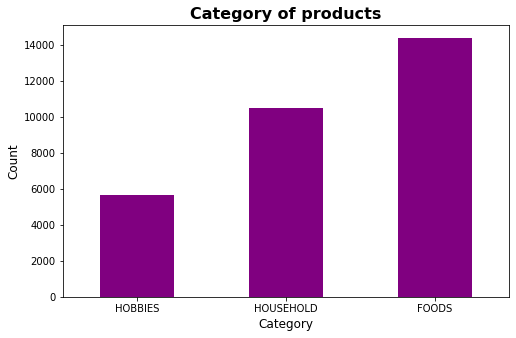

In [15]:
sales_valid.groupby('cat_id').count()['id'] \
    .sort_values() \
    .plot(kind='bar', figsize=(8, 5), title='Count of items sold by Category', color='Purple')
plt.xticks(rotation=0)
plt.title(label='Category of products',fontsize=16, fontweight='bold') 
plt.xlabel('Category', fontsize=12)
plt.ylabel('Count', fontsize=12)
plt.show()

We can see food items are most sold out of all the categories.

## Category wise sales percentage




In [16]:
d_cols = [c for c in sales_valid.columns if 'd_' in c]

In [17]:
sales_valid['total_sale'] = sales_valid[d_cols].sum(axis = 1)

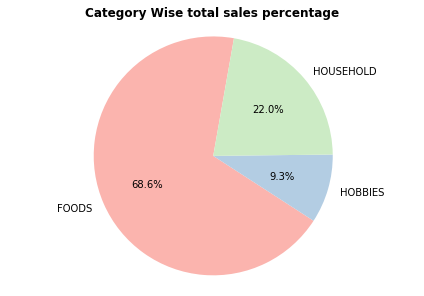

In [18]:
#Caculating the sales ratio for the 3 categories
cat_wise_sales = sales_valid.groupby('cat_id').agg({"total_sale":"sum"})/sales_valid.total_sale.sum() * 100
cat_wise_sales = cat_wise_sales.reset_index()
#Plotting the sales ratio for the 3 categories
fig1, ax1 = plt.subplots()
pal=sns.color_palette("Pastel1")
ax1.pie(cat_wise_sales['total_sale'],labels= cat_wise_sales['cat_id'] , 
        autopct='%1.1f%%',startangle=80, colors=pal
        )# Equal aspect ratio ensures that pie is drawn as a circle
ax1.axis('equal')  
plt.tight_layout()
plt.title("Category Wise total sales percentage",fontweight = "bold")
plt.show()

## Count of items sold in each state

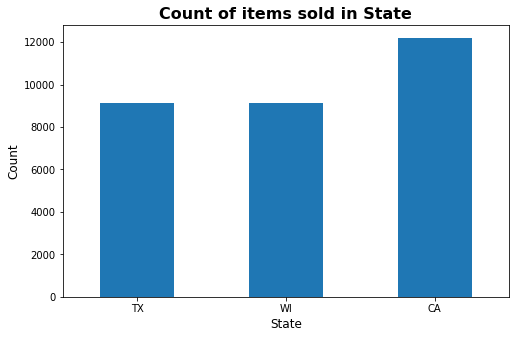

In [19]:
sales_valid.groupby('state_id').count()['id'] \
    .sort_values() \
    .plot(kind='bar', figsize=(8, 5), color=next(color_cycle))
plt.xticks(rotation=0)
plt.title(label='Count of items sold in State',fontsize=16, fontweight='bold') 
plt.xlabel('State', fontsize=12)
plt.ylabel('Count', fontsize=12)
plt.show()

## Sales Distribution

In [20]:
sales_dist =  sales_valid.groupby(['state_id','store_id','cat_id','dept_id'], as_index= False)['item_id'].count().dropna()
sales_dist['USA'] = 'United States'
sales_dist.rename(columns={'state_id':'State','store_id':'Store','cat_id':'Category','dept_id':'Department','item_id':'Count'},inplace=True)
fig = px.treemap(sales_dist, path=['USA','State','Store','Category','Department'],
                 values = 'Count',
                 color = 'Count',
                 color_continuous_scale= px.colors.sequential.Viridis,
                 title = 'Sales Distribution Across CA TX WI')
fig.show()

## Department wise sales percentage

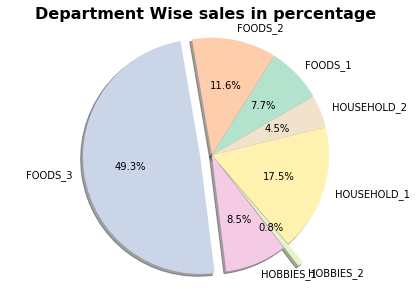

In [21]:
#Calculating the sales ratio for the 10 stores
dept_sales=sales_valid.groupby('dept_id').agg({"total_sale":"sum"})/sales_valid.total_sale.sum() * 100
#Plotting the sales ratio for the 10 stores
dept_sales = dept_sales.reset_index()
fig1, ax1 = plt.subplots()
explode = (0, 0, 0.1, 0, 0.2, 0, 0)
pal=sns.color_palette("Pastel2")
ax1.pie(dept_sales['total_sale'],labels= dept_sales['dept_id'] , autopct='%1.1f%%', colors=pal,
        explode=explode,
        shadow=True, startangle=30)
ax1.axis('equal')  
plt.tight_layout()
plt.title("Department Wise sales in percentage",fontweight = "bold" , fontsize=16)
plt.show()

From the above plot, we can see the items in FOODS_3 category are sold the most and HOBBIES_2 sold the least.

## Checking sales of a random items  to look across the training data

Taking a random item from department FOODS_3 and to see how it's sales look across the training data.

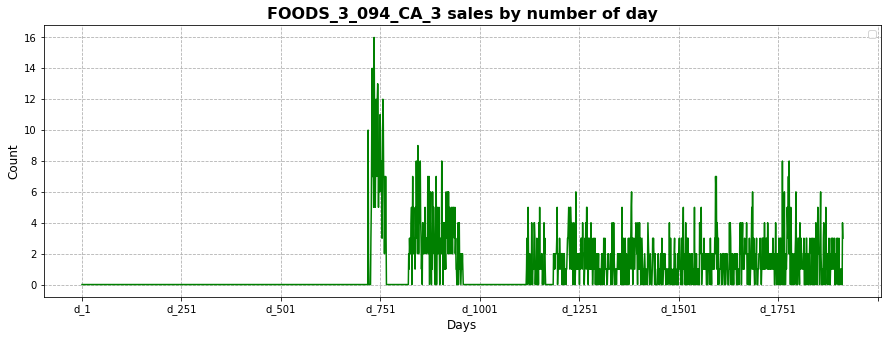

In [22]:
 # sales data columns
# Below we are chaining the following steps in pandas:
# 1. Select the item.
# 2. Set the id as the index, Keep only sales data columns
# 3. Transform so it's a column
# 4. Plot the data
sales_valid.loc[sales_valid['id'] == 'FOODS_3_094_CA_3_validation'] \
    .set_index('id')[d_cols] \
    .T \
    .plot(figsize=(15, 5),color='g',kind='line')
plt.title(label='FOODS_3_094_CA_3 sales by number of day',fontsize=16, fontweight='bold') 
plt.legend('')
plt.xlabel('Days', fontsize=12)
plt.ylabel('Count', fontsize=12)
plt.grid(b=True, which='major', linestyle='--')
plt.show()

From the above graph, we can see that there are days where  item is not available and has no sale. Let's see the same data by the date on which items were sold.


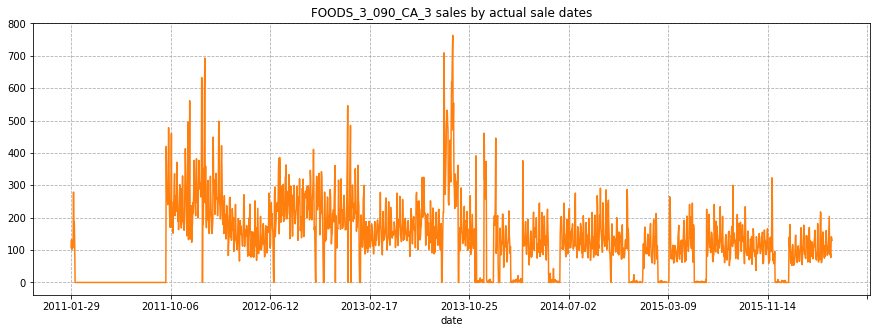

In [23]:
# Merge calendar on our items' data
example = sales_valid.loc[sales_valid['id'] == 'FOODS_3_090_CA_3_validation'][d_cols].T
example = example.rename(columns={8412:'FOODS_3_090_CA_3'}) # Name it correctly
example = example.reset_index().rename(columns={'index': 'd'}) # make the index "d"
example = example.merge(calendar, how='left', validate='1:1')
example.set_index('date')['FOODS_3_090_CA_3'] \
    .plot(figsize=(15, 5),
          color=next(color_cycle),
          title='FOODS_3_090_CA_3 sales by actual sale dates')
plt.grid(b=True, which='major', linestyle='--')
plt.show()

Let's check the sale of items in other department for same store ( i.e., CA_3)

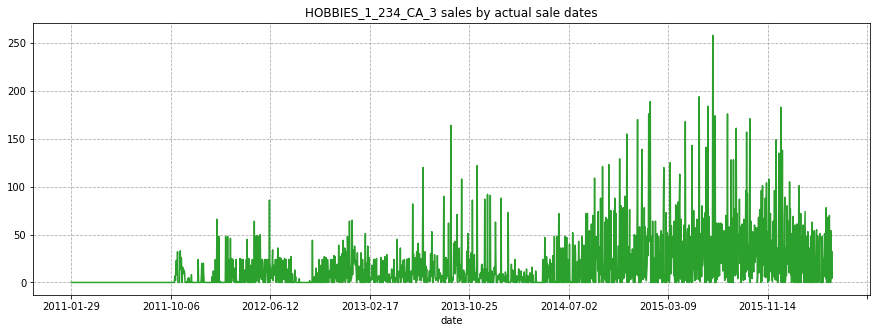

In [24]:
example2 = sales_valid.loc[sales_valid['id'] == 'HOBBIES_1_234_CA_3_validation'][d_cols].T
example2 = example2.rename(columns={6324:'HOBBIES_1_234_CA_3'}) # Name it correctly
example2 = example2.reset_index().rename(columns={'index': 'd'}) # make the index "d"
example2 = example2.merge(calendar, how='left', validate='1:1')
example2.set_index('date')['HOBBIES_1_234_CA_3'] \
    .plot(figsize=(15, 5),
          color=next(color_cycle),
          title='HOBBIES_1_234_CA_3 sales by actual sale dates')
plt.grid(b=True, which='major', linestyle='--')
plt.show()

Lets look some more random of different items!



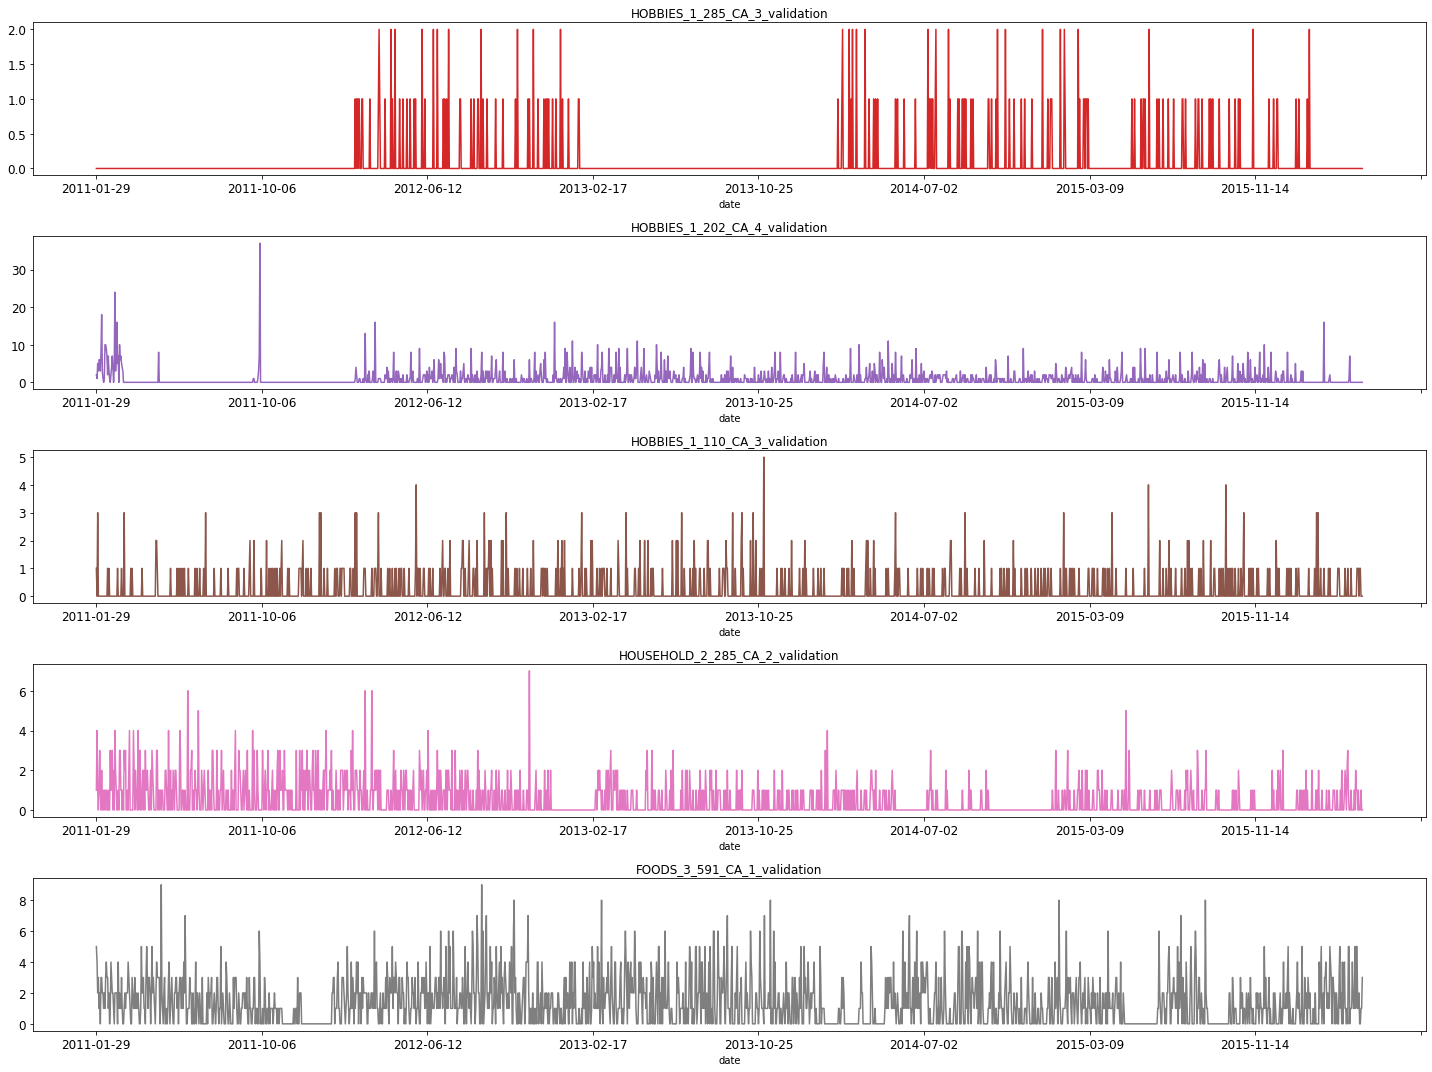

In [25]:
samples = sales_valid.sample(5, random_state=625) \
        .set_index('id')[d_cols] \
    .T \
    .merge(calendar.set_index('d')['date'],
           left_index=True,right_index=True,validate='1:1') \
    .set_index('date')

fig, axs = plt.subplots(5, 1, figsize=(20, 15))
axs = axs.flatten()
ax_idx = 0
for item in samples.columns:
    samples[item].plot(title=item,color=next(color_cycle), fontsize=12,
                              ax=axs[ax_idx])
    ax_idx += 1

plt.tight_layout()
plt.show()

We can see some of the items are unavailable for a period of time.

Sometimes very few items get sold and sometimes demand or the item increases. This could be due to events.

## Per day sale of all the stores of Walmart

In [26]:
sales_valid.groupby(['store_id']).sum(numeric_only=True)

,d_1,d_2,d_3,d_4,d_5,d_6,d_7,d_8,d_9,d_10,d_11,d_12,d_13,d_14,d_15,d_16,d_17,d_18,d_19,d_20,d_21,d_22,d_23,d_24,d_25,d_26,d_27,d_28,d_29,d_30,d_31,d_32,d_33,d_34,d_35,d_36,d_37,d_38,d_39,d_40,...,d_1875,d_1876,d_1877,d_1878,d_1879,d_1880,d_1881,d_1882,d_1883,d_1884,d_1885,d_1886,d_1887,d_1888,d_1889,d_1890,d_1891,d_1892,d_1893,d_1894,d_1895,d_1896,d_1897,d_1898,d_1899,d_1900,d_1901,d_1902,d_1903,d_1904,d_1905,d_1906,d_1907,d_1908,d_1909,d_1910,d_1911,d_1912,d_1913,total_sale
store_id,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
CA_1,4337,4155,2816,3051,2630,3276,3450,5437,4340,3157,2995,2710,2928,3078,4316,4354,2757,2430,2272,2009,3015,4553,3966,3264,2441,2377,2414,2701,3719,3548,2246,2549,2559,2568,2978,4096,4832,3138,2997,2772,...,3329,4285,5659,6197,4242,3776,3770,3970,4904,6139,4669,3905,3788,3339,4076,4983,5877,6496,4812,4063,3964,3655,4719,6112,5969,4484,3579,3478,3637,3982,5437,5954,4345,3793,3722,3709,4387,5577,6113,7698216
CA_2,3494,3046,2121,2324,1942,2288,2629,3729,2957,2218,2123,1901,2436,2584,3455,3563,1801,1797,1741,1614,2214,3080,3087,2601,1810,1851,1652,2187,3516,2692,1894,1958,1837,2010,2105,3199,3272,1970,1800,2064,...,3411,4127,2779,2300,3496,3645,3322,3329,4796,6429,6296,3645,3795,3489,3581,4787,6048,6542,3971,3480,3731,3760,4447,6353,6297,3891,3798,3545,3441,4440,5352,5760,3830,3631,3691,3303,4457,5884,6082,5685475
CA_3,4739,4827,3785,4232,3817,4369,4703,5456,5581,4912,4447,4544,4406,4380,5187,5780,3303,3758,3641,3099,3320,4694,4794,4631,3593,3342,3310,3575,4774,4540,3604,3846,3821,3757,3904,4894,5895,4274,4084,3754,...,5277,5644,7508,7775,6239,5703,5651,5409,6373,7978,7650,5487,5493,5202,5474,6571,7206,8399,6622,6221,5685,5635,6191,7782,8602,6580,5641,5377,5493,5337,6936,8271,6068,5683,5235,5018,5623,7419,7721,11188180
CA_4,1625,1777,1386,1440,1536,1389,1469,1988,1818,1535,1368,1195,1434,1312,1652,1933,1183,1511,1190,1113,1476,1543,1618,1501,1286,1371,1138,1384,1643,1711,1452,1429,1320,1375,1457,1595,2058,1571,1418,1361,...,2179,2608,2954,3149,2564,2457,2398,2520,2621,3241,2681,2445,2243,2322,2470,2581,3040,3140,2788,2632,2427,2409,2357,3064,3195,2535,2174,2214,2498,2496,2839,3047,2809,2677,2500,2458,2628,2954,3271,4103676
TX_1,2556,2687,1822,2258,1694,2734,1691,2820,2887,2174,1607,2149,1895,2256,2944,3432,1921,2217,1962,1821,1951,2571,2810,2071,1933,1723,1825,1886,2629,2688,1985,1967,1860,2052,1753,2642,3031,2272,1788,2180,...,2990,2999,3633,4133,2757,2817,2854,2637,3478,4023,4589,3026,2499,2801,2631,3389,4018,4275,3032,3215,3201,3100,3301,4068,4148,3168,3029,2852,2924,3084,3724,4192,3410,3257,2901,2776,3022,3700,4033,5595292
TX_2,3852,3937,2731,2954,2492,3439,2588,3772,3657,2932,2628,2669,2515,2883,4000,4779,2679,2927,2606,2449,2615,3705,3845,3006,2725,2268,2488,2506,3565,3660,2548,3023,2383,2545,2718,3627,4379,2954,2495,2705,...,3764,4224,4528,4928,3666,3664,3900,3360,4600,5046,4759,3740,2899,3137,3355,4113,4785,5170,3791,3721,3366,3795,3748,4820,5035,4033,3484,3348,3851,3897,4475,4998,3311,3727,3384,3446,3902,4483,4292,7214384
TX_3,3030,3006,2225,2169,1726,2833,1947,2848,2832,2213,1989,1922,1699,2063,3137,3514,2119,2316,2038,2142,2145,2874,3134,2220,1970,1823,1862,1894,2392,2738,2022,2092,1902,2042,2113,2969,3013,2397,2052,2056,...,3416,3533,4049,4367,3550,3345,3587,3308,4157,4526,3988,3537,2924,2890,3320,4350,4292,4606,3674,3530,3771,3705,3717,4472,4635,3973,3905,3494,3517,3819,4261,4519,3147,3938,3315,3380,3691,4083,3957,6089330
WI_1,2704,2194,1562,1251,2,2049,2815,3248,1674,1355,1335,1410,1349,1946,2634,2012,1522,1363,1300,1459,1872,2596,1415,939,1089,1413,1449,1830,2154,1784,1327,1352,1279,1338,1560,1867,1996,1453,1359,1157,...,3028,3509,5102,5003,3249,3033,2751,2718,5094,6150,3550,3039,2780,2692,2858,4362,5119,5370,3168,3231,2996,3288,3866,6182,4995,3493,3388,3169,3241,3862,4862,4812,3236,3069,3242,3324,3991,4772,4874,5149062
WI_2,2256,1922,2018,2522,1175,2244,2232,2643,2140,1836,1526,1846,1785,2015,2442,2336,1612,1980,1628,1678,1813,2014,1592,1356,1330,1719,15

## Store wise sales

In [27]:
sales_valid['total_sale'] = sales_valid[d_cols].sum(axis = 1)
sales_valid.groupby('store_id').agg({'total_sale':'sum'}).reset_index()

,store_id,total_sale
0,CA_1,7698216
1,CA_2,5685475
2,CA_3,11188180
3,CA_4,4103676
4,TX_1,5595292
5,TX_2,7214384
6,TX_3,6089330
7,WI_1,5149062
8,WI_2,6544012
9,WI_3,6427782


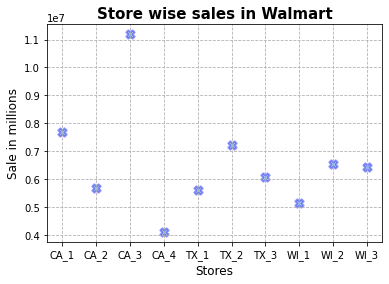

In [28]:
#Sales across 10 stores
store_sales=sales_valid.groupby('store_id').agg({'total_sale':'sum'})
store_sales = store_sales.reset_index()
plt.scatter(x = store_sales['store_id'],y = store_sales['total_sale'], cmap= 'Blues',s=70,
            alpha=0.4, edgecolors='blue', linewidth=2, marker="X")        
plt.title("Store wise sales in Walmart", fontsize=15, fontweight='bold')
plt.xlabel('Stores', fontsize=12)
plt.ylabel('Sale in millions', fontsize=12)
plt.grid(b=True, which='major', linestyle='--')
plt.show()

Store CA_3 has the maximum sale whereas store CA_4 has the minimum sale.

## Total sale of all categories across three states

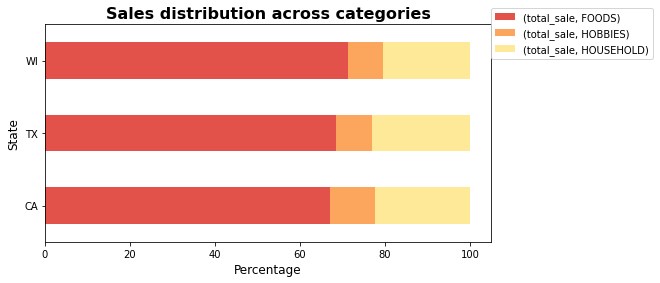

In [29]:
st_ct_sales = sales_valid.groupby(['state_id','cat_id']).agg({"total_sale":"sum"}).groupby(level=0).apply(lambda x: 100 * x / float(x.sum())).unstack()
pal = sns.color_palette("Spectral")
st_ct_sales.plot(kind= 'barh', stacked= 'True', figsize=(8,4),color=pal)
plt.title("Sales distribution across categories", fontweight='bold',fontsize = 16)
plt.legend(loc=(1,0.84))
plt.xlabel('Percentage',fontsize = 12)
plt.ylabel('State', fontsize = 12)
plt.show()

## Variation of price of an item over time in all stores


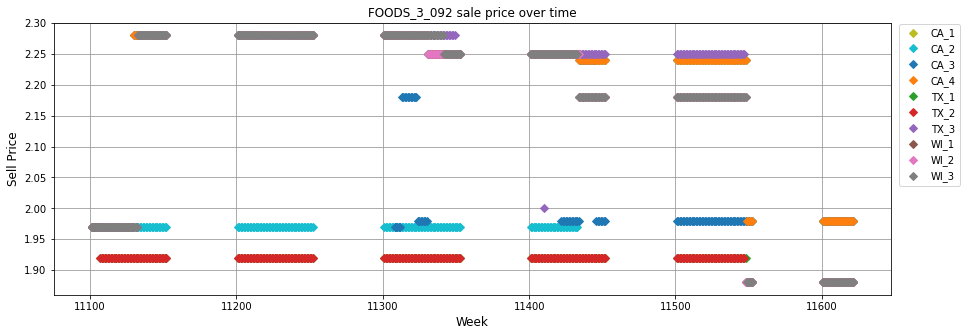

In [30]:
fig, ax = plt.subplots(figsize=(20, 5))
stores = []
for store, d in sell_prices.query('item_id == "FOODS_3_093"').groupby('store_id'):
    d.plot(x='wm_yr_wk',y='sell_price',style='D',
          color= next(color_cycle),figsize=(15, 5),
          title='FOODS_3_092 sale price over time',ax=ax,legend=store)      
    stores.append(store)
    plt.legend()
plt.legend(stores, loc=(1.01,0.4))
plt.grid(b=True, which='major', color='#999999', linestyle='-')
plt.xlabel('Week' ,fontsize=12)
plt.ylabel('Sell Price', fontsize=12)
plt.show()

The above graph shows the variation of prices of a single item in all the stores over weeks.

## Price distribution across categories

In [31]:
print(sell_prices['sell_price'].max())
print(sell_prices['sell_price'].min())

107.32
0.01


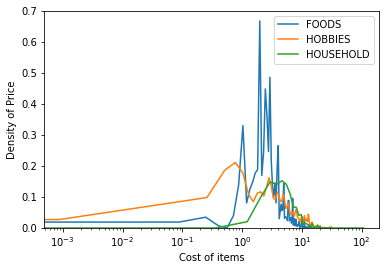

<Figure size 1080x432 with 0 Axes>

In [32]:
sell_prices['Category'] = sell_prices["item_id"].str.split("_", expand = True)[0]
plot = plt.subplots(1,1)
plot1= sns.kdeplot(sell_prices[sell_prices['Category']=='FOODS']['sell_price'])
plot2= sns.kdeplot(sell_prices[sell_prices['Category']=='HOBBIES']['sell_price'])
plot3 = sns.kdeplot(sell_prices[sell_prices['Category']=='HOUSEHOLD']['sell_price'])
plt.legend(labels=['FOODS', 'HOBBIES', 'HOUSEHOLD'])
plt.ylabel("Density of Price")
plt.xlabel("Cost of items")
plt.xscale("log")
plt.figure(figsize=(15,6))
plt.show()

## Seasonal decomposition


In [33]:
store_sum = sales_valid.groupby(['store_id']).sum().T.reset_index(drop = True)
store_mean = sales_valid.groupby(['store_id']).mean().T.reset_index(drop = True)

In [34]:
#Setting the start date
base = datetime.datetime(2011,1,29)
#Calculating the total sales in a day
day_sales = pd.DataFrame(sales_valid[d_cols].sum(axis =0),columns = ["sales"])
#Adding the date column
day_sales['date'] = [base + datetime.timedelta(days=x) for x in range(1913)]
day_sales.set_index('date', drop=True, inplace=True)
day_sales.sort_index(inplace=True)
day_sales.head()

,sales
date,
2011-01-29,32631
2011-01-30,31749
2011-01-31,23783
2011-02-01,25412
2011-02-02,19146


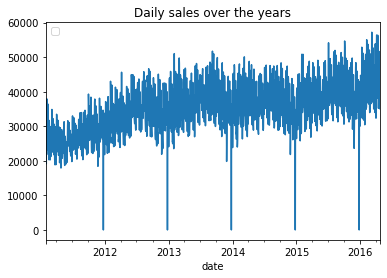

In [35]:
fig = day_sales.plot(title = "Daily sales over the years")
fig.legend("")

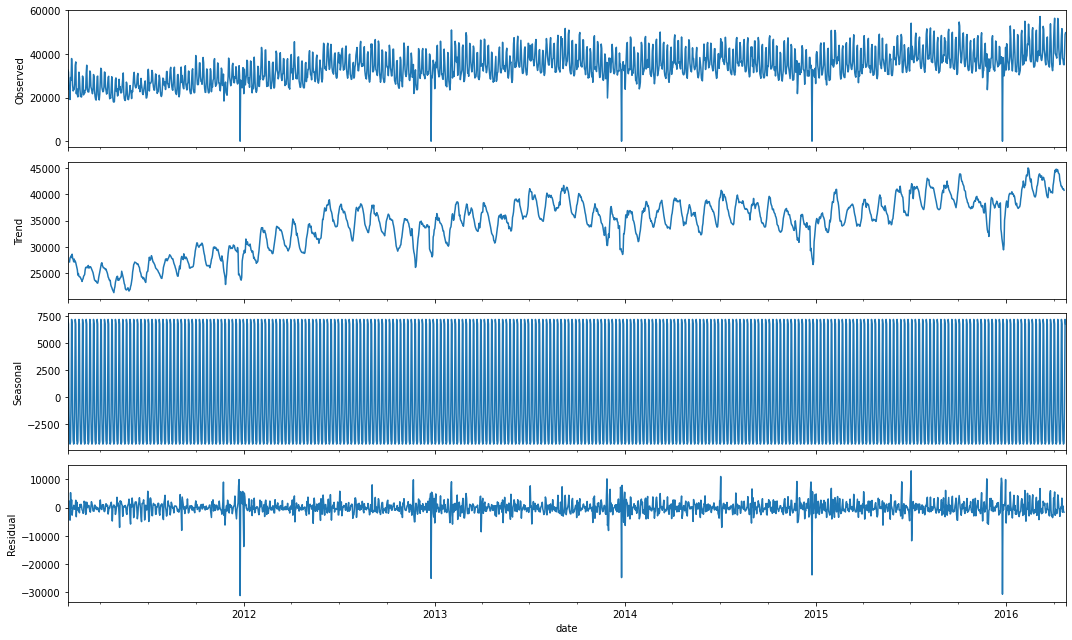

In [36]:
from pylab import rcParams
rcParams['figure.figsize'] = 15, 9
decomposition = seasonal_decompose(day_sales, model='additive')
fig = decomposition.plot()
plt.show()

From above we observe,

Observed: We see our actual time series (daily sales) accross the years

Trend: Our trend seems to be increasing over the years

Seasonality:The graph shows a strong weekly seasonality

Residual:The graph shows are random variations in the series.

##Monthly Sales across states


Text(0, 0.5, 'Sales')

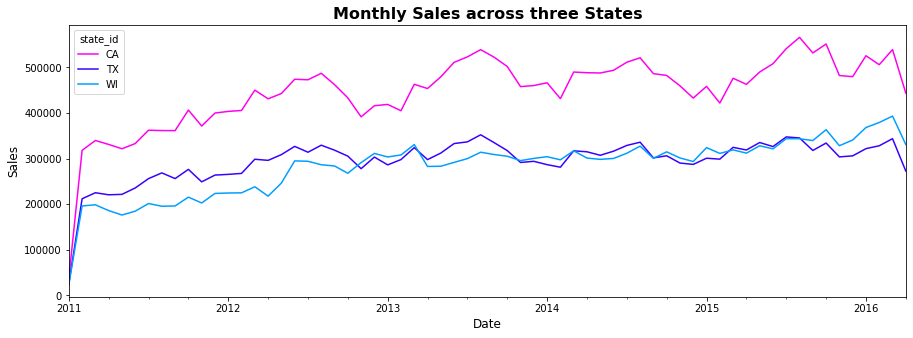

In [37]:
mnth_st_sales = sales_valid.groupby("state_id")[d_cols].sum().reset_index().set_index('state_id').T
mnth_st_sales['date'] = [base + datetime.timedelta(days=x) for x in range(1913)]
mnth_st_sales.set_index('date', drop=True, inplace=True)
mnth_st_sales.sort_index(inplace=True)
mnth_st_sales.head()
mss = mnth_st_sales.groupby(pd.Grouper(freq='1M')).sum()
pal = sns.color_palette("hsv_r")
fig=mss.plot(color= pal,figsize=(15, 5))
fig.set_title("Monthly Sales across three States", fontsize=16, fontweight='bold')
fig.set_xlabel('Date', fontsize=12)
fig.set_ylabel('Sales', fontsize=12)


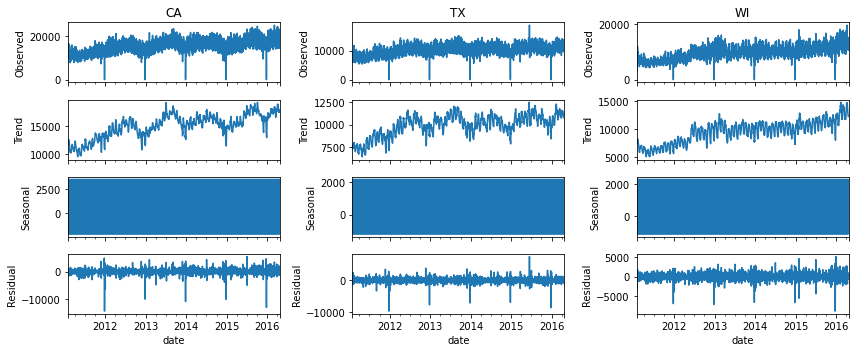

In [38]:
#Plotting the sales time series decomposition for each state
res1 = seasonal_decompose(mnth_st_sales["CA"], model='additive')
res2 = seasonal_decompose(mnth_st_sales["TX"], model='additive')
res3 = seasonal_decompose(mnth_st_sales["WI"], model='additive')
def plotseasonal(res, axes ):
    res.observed.plot(ax=axes[0], legend=False)
    axes[0].set_ylabel('Observed')
    res.trend.plot(ax=axes[1], legend=False)
    axes[1].set_ylabel('Trend')
    res.seasonal.plot(ax=axes[2], legend=False)
    axes[2].set_ylabel('Seasonal')
    res.resid.plot(ax=axes[3], legend=False)
    axes[3].set_ylabel('Residual')

fig, axes = plt.subplots(ncols=3, nrows=4, sharex=True, figsize=(12,5))
plotseasonal(res1, axes[:,0])
axes[0,0].set_title("CA")
plotseasonal(res2, axes[:,1])
axes[0,1].set_title("TX")
plotseasonal(res3, axes[:,2])
axes[0,2].set_title("WI")
plt.tight_layout()
plt.show()


## Weekly sales across categories

Text(0, 0.5, 'Sales')

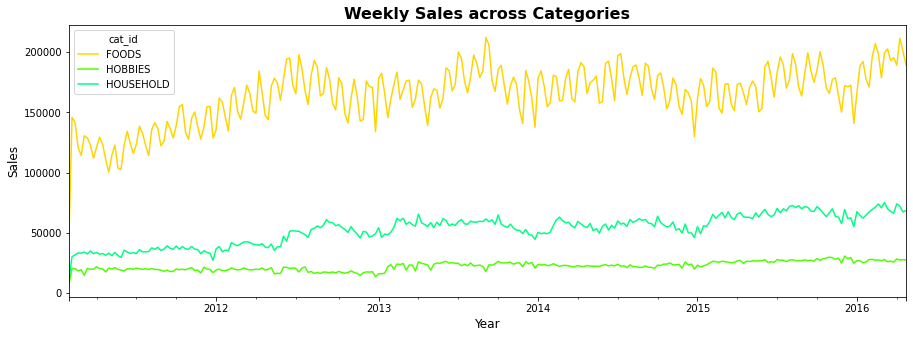

In [39]:
wk_ct_sales = sales_valid.groupby("cat_id")[d_cols].sum().reset_index().set_index('cat_id').T
wk_ct_sales['date'] = [base + datetime.timedelta(days=x) for x in range(1913)]
wk_ct_sales.set_index('date', drop=True, inplace=True)
wk_ct_sales.sort_index(inplace=True)
wk_ct_sales.head()
mss = wk_ct_sales.groupby(pd.Grouper(freq='1W')).sum()
pal = sns.color_palette("hsv")
fig=mss.plot(title="Weekly Sales across Categories", color= pal,figsize=(15, 5))
fig.set_title("Weekly Sales across Categories", fontsize=16, fontweight='bold')
fig.set_xlabel('Year', fontsize=12)
fig.set_ylabel('Sales', fontsize=12)


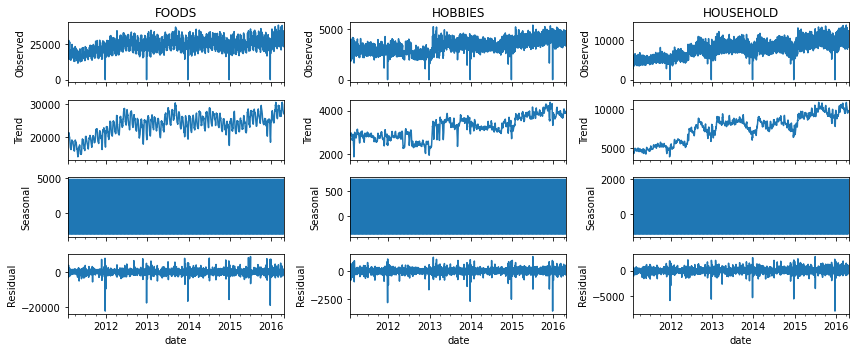

In [40]:
#Plotting the sales time series decomposition for each state
res1 = seasonal_decompose(wk_ct_sales["FOODS"], model='additive')
res2 = seasonal_decompose(wk_ct_sales["HOBBIES"], model='additive')
res3 = seasonal_decompose(wk_ct_sales["HOUSEHOLD"], model='additive')
def plotseasonal(res, axes ):
    res.observed.plot(ax=axes[0], legend=False)
    axes[0].set_ylabel('Observed')
    res.trend.plot(ax=axes[1], legend=False)
    axes[1].set_ylabel('Trend')
    res.seasonal.plot(ax=axes[2], legend=False)
    axes[2].set_ylabel('Seasonal')
    res.resid.plot(ax=axes[3], legend=False)
    axes[3].set_ylabel('Residual')

fig, axes = plt.subplots(ncols=3, nrows=4, sharex=True, figsize=(12,5))

plotseasonal(res1, axes[:,0])
axes[0,0].set_title("FOODS")
plotseasonal(res2, axes[:,1])
axes[0,1].set_title("HOBBIES")
plotseasonal(res3, axes[:,2])
axes[0,2].set_title("HOUSEHOLD")
plt.tight_layout()
plt.show()

## Average sales across weeks

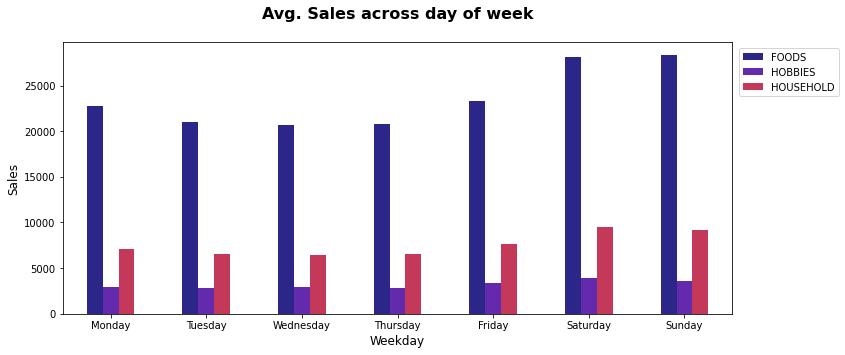

In [41]:
import datetime
import math
wk_ct_sales = sales_valid.groupby("cat_id")[d_cols].sum().reset_index().set_index('cat_id').T
wk_ct_sales['date'] = [base + datetime.timedelta(days=x) for x in range(1913)]
wk_ct_sales.set_index('date', drop=True, inplace=True)
wk_ct_sales.sort_index(inplace=True)
#days = ['Monday','Tuesday','Wednesday','Thursday','Friday','Saturday', 'Sunday']
ct_weekday_sales = wk_ct_sales.groupby([wk_ct_sales.index.dayofweek]).mean()
ct_weekday_sales = ct_weekday_sales.rename(index= {0: 'Monday', 1: 'Tuesday', 2: 'Wednesday', 3: 'Thursday', 4: 'Friday', 5: 'Saturday',6: 'Sunday'})
pal = sns.color_palette("CMRmap")
fig= ct_weekday_sales.plot(kind='bar', figsize=(12,5), color=pal)
plt.ylabel("Sales",fontsize=12)
plt.xlabel("Weekday", fontsize=12)
plt.xticks(rotation=0)
plt.legend(loc=(1.01,0.80))
plt.title("Avg. Sales across day of week\n", fontsize=16, fontweight='bold')
plt.show()

In the above graph, we can see the  weekly seasonality with highest sales on weekends and lowest sales in Wednesday and Thursday.

Overall saturday has more sales than Sunday in the case of Household and Hobbies although the differences are quite small.

## Average sales across month

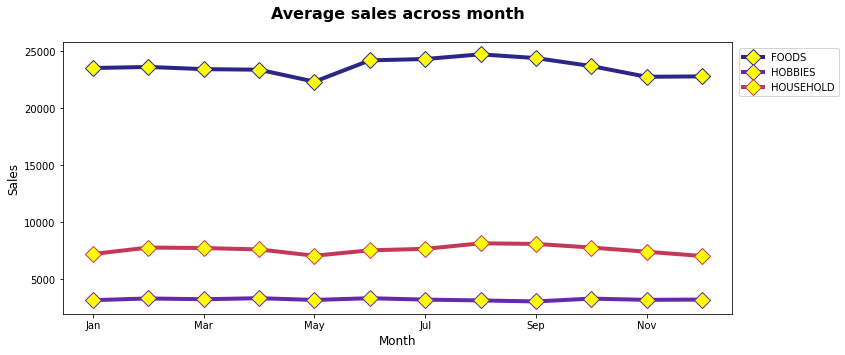

In [42]:
wk_ct_sales = sales_valid.groupby("cat_id")[d_cols].sum().reset_index().set_index('cat_id').T
wk_ct_sales['date'] = [base + datetime.timedelta(days=x) for x in range(1913)]
wk_ct_sales.set_index('date', drop=True, inplace=True)
wk_ct_sales.sort_index(inplace=True)
wk_ct_sales.head()
months = ['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul','Aug', 'Sep', 'Oct', 'Nov', 'Dec'] 
monthly_sales = wk_ct_sales.groupby(wk_ct_sales.index.strftime('%b')).mean().reindex(months)
fig= monthly_sales.plot(figsize=(12,5), color=pal, marker='D',
                        markerfacecolor='yellow',markersize=12 ,
                        linewidth=4)
plt.ylabel("Sales",fontsize=12)
plt.xlabel("Month", fontsize=12)
plt.xticks(rotation=0)
plt.legend(loc=(1.01,0.80))
plt.title("Average sales across month\n", fontsize=16, fontweight='bold')
plt.show()

From the above graph, we can see that the highest sales in Foods and Household items is in the month of August.

In [43]:
#Joining the calender data with the sales data to see the impact of events
calendar['date'] = pd.to_datetime(calendar['date'])
entire_sales= pd.merge(calendar,day_sales, left_on = "date", right_on = "date",how = "right")

In [44]:
entire_sales.head()

,date,wm_yr_wk,weekday,wday,month,year,d,event_name_1,event_type_1,event_name_2,event_type_2,snap_CA,snap_TX,snap_WI,sales
0,2011-01-29,11101,Saturday,1,1,2011,d_1,NaN,NaN,NaN,NaN,0,0,0,32631
1,2011-01-30,11101,Sunday,2,1,2011,d_2,NaN,NaN,NaN,NaN,0,0,0,31749
2,2011-01-31,11101,Monday,3,1,2011,d_3,NaN,NaN,NaN,NaN,0,0,0,23783
3,2011-02-01,11101,Tuesday,4,2,2011,d_4,NaN,NaN,NaN,NaN,1,1,0,25412
4,2011-02-02,11101,Wednesday,5,2,2011,d_5,NaN,NaN,NaN,NaN,1,0,1,19146


## Types of event


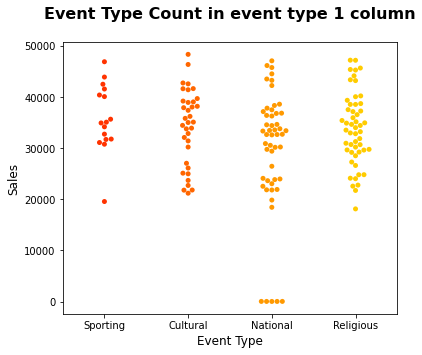

In [45]:
plt.figure(figsize=(6, 5))
sns.swarmplot(x="event_type_1", data=entire_sales[entire_sales["event_type_1"] != "NaN"] , y='sales',
                palette='autumn')
plt.ylabel("Sales",fontsize=12)
plt.xlabel("Event Type", fontsize=12)
plt.xticks(rotation=0)
plt.title("Event Type Count in event type 1 column\n", fontsize=16, fontweight='bold')
plt.show()

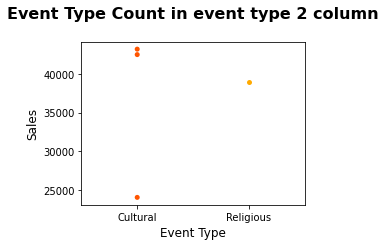

In [46]:
plt.figure(figsize=(4, 3))
sns.swarmplot(x="event_type_2", data=entire_sales[entire_sales["event_type_2"] != "NaN"] , y='sales',
                palette='autumn')
plt.xticks(rotation=0)
plt.ylabel("Sales",fontsize=12)
plt.xlabel("Event Type", fontsize=12)
plt.xticks(rotation=0)
plt.title("Event Type Count in event type 2 column\n", fontsize=16, fontweight='bold')
plt.show()

In [47]:
entire_sales = pd.merge(entire_sales,mnth_st_sales.reset_index(),how = "left",left_on="date",right_on="date")
entire_sales.drop("date",axis = 1,inplace =True)
entire_sales.head()

,wm_yr_wk,weekday,wday,month,year,d,event_name_1,event_type_1,event_name_2,event_type_2,snap_CA,snap_TX,snap_WI,sales,CA,TX,WI
0,11101,Saturday,1,1,2011,d_1,NaN,NaN,NaN,NaN,0,0,0,32631,14195,9438,8998
1,11101,Sunday,2,1,2011,d_2,NaN,NaN,NaN,NaN,0,0,0,31749,13805,9630,8314
2,11101,Monday,3,1,2011,d_3,NaN,NaN,NaN,NaN,0,0,0,23783,10108,6778,6897
3,11101,Tuesday,4,2,2011,d_4,NaN,NaN,NaN,NaN,1,1,0,25412,11047,7381,6984
4,11101,Wednesday,5,2,2011,d_5,NaN,NaN,NaN,NaN,1,0,1,19146,9925,5912,3309


Check for 'NaN' values and replce them with 'Unknown'.

In [48]:
#print("Columns with NaN" , entire_sales.isna().sum(), sep='\n')
replace_NaN = {'event_name_1': "Unknown",'event_name_2': "Unknown", 'event_type_1': "Unknown",'event_type_2': "Unknown"}
entire_sales = entire_sales.fillna(replace_NaN)
print("Columns with NaN" , entire_sales.isna().sum(), sep='\n')

Columns with NaN
wm_yr_wk        0
weekday         0
wday            0
month           0
year            0
d               0
event_name_1    0
event_type_1    0
event_name_2    0
event_type_2    0
snap_CA         0
snap_TX         0
snap_WI         0
sales           0
CA              0
TX              0
WI              0
dtype: int64


We can see that now there is no NaN.

In [49]:
event_days=entire_sales.loc[(entire_sales['event_type_1']!='Unknown') | (entire_sales['event_type_2']!='Unknown')]
no_event_days=entire_sales.loc[(entire_sales['event_type_1']=='Unknown') | (entire_sales['event_type_2']=='Unknown')]

In [50]:
event_days

,wm_yr_wk,weekday,wday,month,year,d,event_name_1,event_type_1,event_name_2,event_type_2,snap_CA,snap_TX,snap_WI,sales,CA,TX,WI
8,11102,Sunday,2,2,2011,d_9,SuperBowl,Sporting,Unknown,Unknown,1,1,1,32736,14696,9376,8664
16,11103,Monday,3,2,2011,d_17,ValentinesDay,Cultural,Unknown,Unknown,0,0,1,21804,9044,6719,6041
23,11104,Monday,3,2,2011,d_24,PresidentsDay,National,Unknown,Unknown,0,0,0,23966,11997,7297,4672
39,11106,Wednesday,5,3,2011,d_40,LentStart,Religious,Unknown,Unknown,1,1,1,22560,9951,6941,5668
46,11107,Wednesday,5,3,2011,d_47,LentWeek2,Religious,Unknown,Unknown,0,0,0,22765,9752,6768,6245
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1843,11603,Monday,3,2,2016,d_1844,PresidentsDay,National,Unknown,Unknown,0,1,1,46152,19231,12115,14806
1845,11603,Wednesday,5,2,2016,d_1846,LentWeek2,Religious,Unknown,Unknown,0,0,0,36545,14555,9904,12086
1874,11607,Thursday,6,3,2016,d_1875,StPatricksDay,Cultural,Unknown,Unknown,0,0,0,35009,14196,10170,10643
1881,11608,Thursday,6,3,2016,d_1882,Purim End,Religious,Unknown,Unknown,0,0,0,34003,15228,9305,9470


## Effect of events on sales

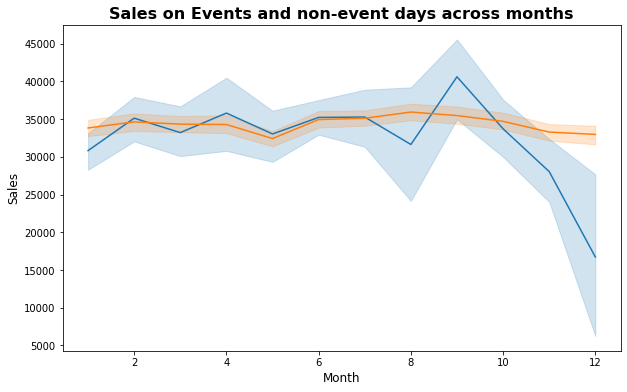

In [51]:
plt.figure(figsize=(10, 6))
sns.lineplot(x='month', y='sales', data=event_days)
sns.lineplot(x='month', y='sales', data=no_event_days)
plt.title('Sales on Events and non-event days across months', fontweight='bold', fontsize=16)
plt.xlabel('Month',fontsize=12)
plt.ylabel('Sales',fontsize=12)
plt.show()

In the above graph, plot with orange color show the sales on the days of events and plot with blue show the sales on the non-event days. We can see how the sales vary during events.

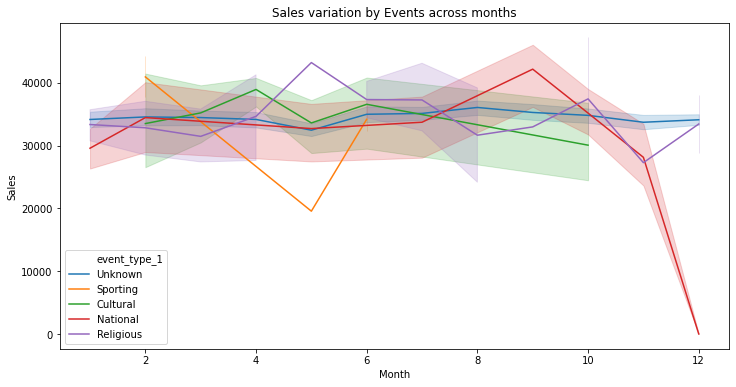

In [52]:
plt.figure(figsize=(12, 6))
sns.lineplot(x='month', y='sales', data=entire_sales, hue='event_type_1')
plt.xlabel("Month")
plt.ylabel('Sales')
plt.title('Sales variation by Events across months')
plt.show()

From the above graph, we can say that overall sales is less in May and December that might be because of sport and national events repectively.


## Snap purchase days

Text(0.5, 1.0, 'Snap Purchase allowed day yearly\n')

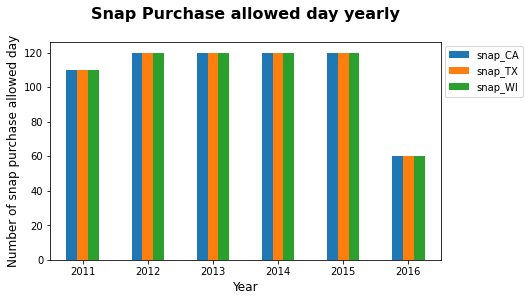

In [53]:
temp = calendar.groupby(["year"])[["snap_CA", "snap_TX", "snap_WI"]].sum()
fig = temp.plot(kind='bar', figsize=(7,4))
plt.ylabel("Number of snap purchase allowed day",fontsize=12)
plt.xlabel("Year", fontsize=12)
plt.xticks(rotation=0)
plt.legend(loc=(1.01,0.75))
plt.title("Snap Purchase allowed day yearly\n", fontsize=16, fontweight='bold')

From the above graph we see that the snap days for 2012 to 2016 are 120 and reduced to half in 2016

## Effect of Snap days on sales

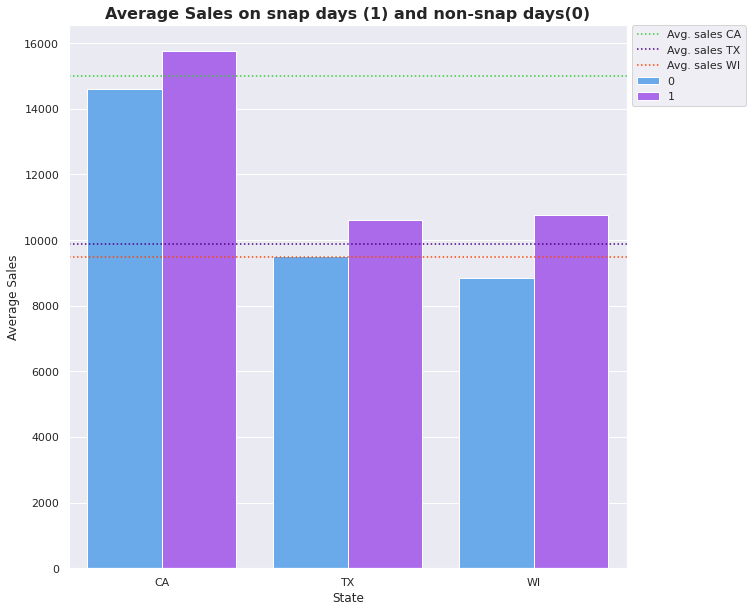

In [55]:
snap_ca = entire_sales.groupby("snap_CA")['CA'].mean().reset_index()
snap_tx = entire_sales.groupby("snap_TX")['TX'].mean().reset_index()
snap_wi = entire_sales.groupby("snap_WI")['WI'].mean().reset_index()
snap_ca.columns = ["Snap","CA"]
snap_tx.columns = ["Snap","TX"]
snap_wi.columns = ["Snap","WI"]
snap_im= pd.merge(snap_ca,snap_tx,on = "Snap")
snap_im = pd.merge(snap_im,snap_wi,on = "Snap")
snap_im = pd.melt(snap_im, id_vars=['Snap'], value_vars=['CA','TX','WI'],var_name='State', value_name='Average Sales')

sns.set(rc={'figure.figsize':(10,10)})
chart=sns.barplot(x= "State", y='Average Sales',hue = 'Snap' , data=snap_im, palette='cool')
chart.axhline(entire_sales.CA.mean(),label = "Avg. sales CA",c='Limegreen', linestyle='dotted')
chart.axhline(entire_sales.TX.mean(),label = "Avg. sales TX",c='Indigo', linestyle='dotted')
chart.axhline(entire_sales.WI.mean(),label = "Avg. sales WI",c='OrangeRed', linestyle='dotted')
var = chart.set_xticklabels(chart.get_xticklabels())
plt.title("Average Sales on snap days (1) and non-snap days(0)", fontsize=16, fontweight='bold')
plt.legend(loc=(1.01,.85))
plt.show()

##  Distribution of snap and event day

In [56]:
snap_event=calendar.groupby(["event_type_1"])[["snap_CA", "snap_TX", "snap_WI"]].sum()
snap_event.head()

,snap_CA,snap_TX,snap_WI
event_type_1,,,
Cultural,10,9,17
National,17,17,12
Religious,20,21,16
Sporting,10,10,10


From the above distribution, Snap days is allowed especially on religious events.

# Split the data for training and validation

I am using the last 30 days' sales as the validation data and the sales of the 1883 days before that as the training data. We need to predict the sales in the validation data using the sales in the training data

In [57]:
train_data = sales_valid[d_cols[-1913:-30]]
val_data = sales_valid[d_cols[-30:]]

# Forecasting models

## Exponential Smoothing

In [58]:
predictions = []
for row in tqdm(train_data[train_data.columns[-30:]].values[:4], desc="Progress"):
    fit = statsmodels.tsa.api.ExponentialSmoothing(row, seasonal_periods=3, seasonal='add',trend=None).fit()
    predictions.append(fit.forecast(30))
predictions = np.array(predictions).reshape((-1, 30))
#error_exponential = np.linalg.norm(predictions[:4] - val_data.values[:4])/len(predictions[0])
#print(error_exponential)
exponential_RMSE=0
for i in range(len(predictions)):
    exponential_RMSE = exponential_RMSE + np.sqrt(mean_squared_error(val_data.values[i],predictions[i])/len(predictions[0]))
exponential_RMSE=exponential_RMSE/len(predictions)
print("Root Mean Square Error:",exponential_RMSE)


Root Mean Square Error: 0.19359248914403746


Function to plot graph

In [60]:
def plot_pred(predictions,train_data,val_data,title):

   pred_1 = predictions[0]
   pred_2 = predictions[1]
   pred_3 = predictions[2]
   pred_4 = predictions[3]
   
   fig = make_subplots(rows=4, cols=1)

   fig.add_trace(
    go.Scatter(x=np.arange(1883), mode='lines', y=train_data.loc[0].values, marker=dict(color='DeepPink'),
               name="Train"),
    row=1, col=1
    )

   fig.add_trace(
    go.Scatter(x=np.arange(1883,1913), y=val_data.loc[0].values, mode='lines', marker=dict(color="SpringGreen"),
               name="Val"),
    row=1, col=1
   )

   fig.add_trace(
    go.Scatter(x=np.arange(1883,1913), y=pred_1, mode='lines', marker=dict(color="DarkMagenta"),
               name="Pred"),
    row=1, col=1
   )

   fig.add_trace(
    go.Scatter(x=np.arange(1883), mode='lines', y=train_data.loc[1].values, marker=dict(color='DeepPink'), showlegend=False),
    row=2, col=1
   )

   fig.add_trace(
    go.Scatter(x=np.arange(1883,1913), y=val_data.loc[1].values, mode='lines', marker=dict(color="SpringGreen"), showlegend=False),
    row=2, col=1
   )

   fig.add_trace(
    go.Scatter(x=np.arange(1883,1913), y=pred_2, mode='lines', marker=dict(color="DarkMagenta"), showlegend=False,
               name="Pred"),
    row=2, col=1
   )

   fig.add_trace(
    go.Scatter(x=np.arange(1883), mode='lines', y=train_data.loc[2].values, marker=dict(color='DeepPink'), showlegend=False),
    row=3, col=1
   )

   fig.add_trace(
    go.Scatter(x=np.arange(1883,1913), y=val_data.loc[2].values, mode='lines', marker=dict(color="SpringGreen"), showlegend=False),
    row=3, col=1
   )

   fig.add_trace(
    go.Scatter(x=np.arange(1883,1913), y=pred_3, mode='lines', marker=dict(color="DarkMagenta"), showlegend=False,
               name="Pred"),
    row=3, col=1
   )

   fig.add_trace(
    go.Scatter(x=np.arange(1883), mode='lines', y=train_data.loc[3].values, marker=dict(color='DeepPink'), showlegend=False),
    row=4, col=1
   )

   fig.add_trace(
    go.Scatter(x=np.arange(1883,1913), y=val_data.loc[3].values, mode='lines', marker=dict(color="SpringGreen"), showlegend=False),
    row=4, col=1
   )

   fig.add_trace(
    go.Scatter(x=np.arange(1883,1913), y=pred_4, mode='lines', marker=dict(color="DarkMagenta"), showlegend=False,
               name="Pred"),
    row=4, col=1
   )
   fig.update_layout(height=600, width= 1000, title_text=title)
   fig.show()

In [61]:
title="Exponential Smoothing"
plot_pred(predictions,train_data,val_data,title)

## Holt Winters Exponential Smoothing

In [62]:
predictions = []
for row in tqdm(train_data[train_data.columns[-30:]].values[:4]):
    #fit = Holt(row).fit(smoothing_level = 0.3, smoothing_slope = 0.01)
    fit = statsmodels.tsa.holtwinters.ExponentialSmoothing(row, seasonal_periods=4, trend='add', seasonal='add').fit(optimized=True)
    predictions.append(fit.forecast(30))
predictions = np.array(predictions).reshape((-1, 30))
#error_holt = np.linalg.norm(predictions - val_data.values[:len(predictions)])/len(predictions[0])
#print(error_holt)
holt_RMSE=0
for i in range(len(predictions)):
    holt_RMSE = holt_RMSE + np.sqrt(mean_squared_error(val_data.values[i],predictions[i])/len(predictions[0]))
holt_RMSE = holt_RMSE/len(predictions)
print("Root Mean Square Error:",holt_RMSE)


Root Mean Square Error: 0.22895529221849295


In [63]:
title="Holt Winters Eponnential Smoothing"
plot_pred(predictions,train_data,val_data,title)

## Moving average

In [64]:
predictions = []
for i in range(len(val_data.columns)):
    if i == 0:
        predictions.append(np.mean(train_data[train_data.columns[-30:]].values, axis=1))
    if i < 31 and i > 0:
        predictions.append(0.5 * (np.mean(train_data[train_data.columns[-30+i:]].values, axis=1) + \
                                  np.mean(predictions[:i], axis=0)))
    if i > 31:
        predictions.append(np.mean([predictions[:i]], axis=1))
    
predictions = np.transpose(np.array([row.tolist() for row in predictions]))
ma_RMSE=0
for i in range(len(predictions)):
    ma_RMSE = ma_RMSE + np.sqrt(mean_squared_error(val_data.values[i],predictions[i])/len(predictions[0]))
ma_RMSE = ma_RMSE/len(predictions)
print("Root Mean Square Error:",ma_RMSE)

Root Mean Square Error: 0.25025447362563197


In [65]:
title="Moving Average"
plot_pred(predictions,train_data,val_data,title)

### SARIMAX model

In [66]:
from sklearn.metrics import mean_squared_error
predictions = []
for rows in tqdm(train_data[train_data.columns[:]].values[:4]):
  fit = sm.tsa.statespace.SARIMAX(rows, seasonal_order=(0, 1, 1, 7), trend='c').fit()
  predictions.append(fit.forecast(30))
predictions = np.array(predictions).reshape((-1,30))
sarimax_RMSE=0
for i in range(len(predictions)):
    sarimax_RMSE = sarimax_RMSE + np.sqrt(mean_squared_error(val_data.values[i],predictions[i])/len(predictions[0]))
sarimax_RMSE = sarimax_RMSE/len(predictions)
print("Root Mean Square Error:",sarimax_RMSE)


Root Mean Square Error: 0.18527420048903143


In [67]:
title="SARIMAX model"
plot_pred(predictions,train_data,val_data,title)

## Prophet


In [68]:
dates = ["2016-4-" + str(i) for i in range(1, 31)]
predictions = []
for row in tqdm(train_data[train_data.columns[-30:]].values[:4]):
    df = pd.DataFrame(np.transpose([dates, row]))
    df.columns = ["ds", "y"]
    model = Prophet(weekly_seasonality=True)
    model.fit(df)
    future = model.make_future_dataframe(periods=30)
    forecast = model.predict(future)["yhat"].loc[30:].values
    predictions.append(forecast)
predictions = np.array(predictions).reshape((-1, 30))
prophet_RMSE=0
for i in range(len(predictions)):
    prophet_RMSE = prophet_RMSE + np.sqrt(mean_squared_error(val_data.values[i],predictions[i])/len(predictions[0]))
prophet_RMSE = prophet_RMSE/len(predictions)
print("Root Mean Square Error:",prophet_RMSE)

INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:n_changepoints greater than number of observations. Using 23.
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:n_changepoints greater than number of observations. Using 23.
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:n_changepoints greater than number of observations. Using 23.
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run


Root Mean Square Error: 0.2249415160619021


In [69]:
title="Prophet"
plot_pred(predictions,train_data,val_data,title)

# Comparison of models

In [70]:
error = [ exponential_RMSE,holt_RMSE,ma_RMSE,sarimax_RMSE, prophet_RMSE]
names = [ "Exponential smoothing","Holt Winters","Moving average",  "SARIMAX", "Prophet"]
df = pd.DataFrame(np.transpose([error, names]))
df.columns = ["RMSE Loss", "Model"]
px.bar(df, y="RMSE Loss", x="Model", color="Model", title="RMSE Loss",
       template='seaborn',
       color_discrete_sequence=px.colors.sequential.Sunsetdark)